# Knowledge Distillation MNIST

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [111]:
defaults.cmap='binary' # Sets how to interpret the images

In [3]:
BS = 512
DEVICE = "cuda:0"

## Fetch Data and Create DataBunch

In [39]:
path = untar_data(URLs.MNIST)

KeyboardInterrupt: 

In [36]:
#! cd /user/student.aau.dk/kbargs15/.fastai/data/; rm mnist_png.tgz

In [50]:
! cd /user/student.aau.dk/kbargs15/.fastai/data/k/mnist_png/training; ls

2  7  8  9


In [31]:
path.ls()

[PosixPath('/user/student.aau.dk/kbargs15/.fastai/data/mnist_png/testing')]

In [112]:
data = (ImageList.from_folder(path/'testing', convert_mode='L')
            .split_by_rand_pct()
            .label_from_folder()
            .transform(([*rand_pad(padding=3, size=28, mode='zeros')], []))
            .databunch(bs=BS)
            .normalize())

2 torch.Size([1, 28, 28])


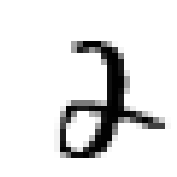

In [113]:
x,y = data.train_ds[0]
x.show()
print(y,x.shape)

## Create the Model

In [61]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [62]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [63]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [64]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [77]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [78]:
xb,yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [79]:
learn_t = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time
0,2.378978,2.001419,0.373851,00:01
1,1.818413,9.367549,0.020429,00:01
2,1.401812,13.566514,0.000000,00:01
3,1.085832,3.975040,0.104188,00:01
4,0.861158,2.410887,0.443309,00:01
5,0.697288,0.614861,0.839632,00:01
6,0.576240,0.663255,0.814096,00:01
7,0.483985,0.168191,0.963228,00:01
8,0.412670,0.120407,0.975485,00:01
9,0.353857,0.105231,0.976507,00:01


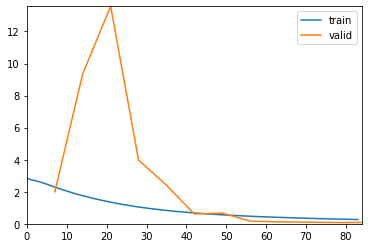

In [80]:
learn_t.fit_one_cycle(12, max_lr=0.05)

In [81]:
learn_t.save("learn_t")

In [83]:
learn_t.load("learn_t");

## KD

In [70]:
def distillation(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

In [93]:
### Training set ###
preds,y = learn_t.get_preds(ds_type=DatasetType.Train)
# Get predicted classes
_, preds_class = preds.max(1)
# Get Filenames
df=pd.DataFrame({ 'file':learn_t.data.train_ds.items})
# Add true labels
df['y'] = pd.DataFrame(y.numpy())
# Add predictions
df['y_teach'] = pd.DataFrame(preds_class.numpy())
# Combine true label and prediction as tuple
df['y_tuple'] = df[['y','y_teach']].apply(tuple, axis=1)
# Drop True labels and prediction column
df = df.drop(df.columns[[1, 2]], axis=1)

In [94]:
### Validation set ###
# Run inference 
preds,y = learn_t.get_preds(ds_type=DatasetType.Valid)
# Get predicted classes
_, preds_class = preds.max(1)
# Get Filenames
df1=pd.DataFrame({ 'file':learn_t.data.valid_ds.items})
# Add true labels
df1['y'] = pd.DataFrame(y.numpy())
# Add predictions
df1['y_teach'] = pd.DataFrame(preds_class.numpy())
# Combine true label and prediction as tuple
df1['y_tuple'] = df1[['y','y_teach']].apply(tuple, axis=1)
# Drop True labels and prediction column
df1 = df1.drop(df1.columns[[1, 2]], axis=1)

In [95]:
final_df=pd.concat([df, df1])
final_df.head()

,file,y_tuple
0,/user/student.aau.dk/kbargs15/.fastai/data/mni...,"(0.0, 0.0)"
1,/user/student.aau.dk/kbargs15/.fastai/data/mni...,"(2.0, 2.0)"
2,/user/student.aau.dk/kbargs15/.fastai/data/mni...,"(2.0, 2.0)"
3,/user/student.aau.dk/kbargs15/.fastai/data/mni...,"(2.0, 2.0)"
4,/user/student.aau.dk/kbargs15/.fastai/data/mni...,"(2.0, 2.0)"


In [115]:
tfms = get_transforms(do_flip=False)
data = (ImageList.from_df(final_df,'/')
                 .split_by_rand_pct()
                 .label_from_df(cols='y_tuple')
                 .transform(tfms, size=26).databunch())

In [ ]:
data.show_batch()

In [131]:
def loss_fn_kd(outputs, two_labels):
    labels, teacher_outputs = two_labels
    
    alpha = 0.9
    T = 20
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [132]:
learn_s = cnn_learner(data, models.resnet18, pretrained=False, metrics=accuracy,loss_func=loss_fn_kd)

In [133]:
learn_s.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time


ValueError: too many values to unpack (expected 2)

In [135]:
xb, yb = data.one_batch()

In [136]:
yb.shape

torch.Size([64, 525])

In [137]:
yb[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 